# Cell Nuclei Separation using Watershed Segmentation

**Task:**  
To separate touching cell nuclei in microscopic images.

**Method Used:**  
Marker-controlled Watershed Segmentation

**Dataset:**  
Data Science Bowl Cell Nuclei Dataset (Kaggle)

**Comparison:**  
Watershed segmentation with markers vs without markers

**Learning Objective:**  
To understand how marker-based control reduces over-segmentation in
watershed algorithms.

## 1. Import Required Libraries

This section imports libraries for image processing, segmentation,
morphological operations, and visualization.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, color, filters, morphology, segmentation, measure
from scipy import ndimage as ndi

import kagglehub

## 2. Download and Load Dataset

The Data Science Bowl 2018 Cell Nuclei dataset is downloaded automatically
using KaggleHub.

In [2]:
import kagglehub

dataset_path = kagglehub.dataset_download(
    "mahmudulhasantasin/data-science-bowl-2018-competition-merged-mask"
)

print("Dataset path:", dataset_path)

Using Colab cache for faster access to the 'data-science-bowl-2018-competition-merged-mask' dataset.
Dataset path: /kaggle/input/data-science-bowl-2018-competition-merged-mask


In [33]:
import os

def find_images_folder(base_path):
    for root, dirs, files in os.walk(base_path):
        if "images" in dirs:
            return os.path.join(root, "images")
    return None

IMAGE_DIR = find_images_folder(dataset_path)

print("Image directory:", IMAGE_DIR)

Image directory: /kaggle/input/data-science-bowl-2018-competition-merged-mask/data science bowl 2018/stage1_train 2/ec031f176dafe0b36547068ce42eab39428ec7995dac1b3ea52d1db79b61fdeb/images


In [25]:
from skimage import io
import numpy as np

image_files = sorted(os.listdir(IMAGE_DIR))
sample_index = 0

image = io.imread(os.path.join(IMAGE_DIR, image_files[sample_index]))

print("Image shape:", image.shape)

## Preprocessing
- Convert image to grayscale
- Normalize intensity
- Convert mask to binary

In [35]:
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import opening, disk

# Remove alpha channel if present
if len(image.shape) == 3 and image.shape[2] == 4:
    image = image[:, :, :3]

# Convert to grayscale
if len(image.shape) == 3:
    gray = rgb2gray(image)
else:
    gray = image

# Normalize
gray = (gray - gray.min()) / (gray.max() - gray.min())

# Foreground extraction using Otsu
threshold = threshold_otsu(gray)
foreground = gray > threshold

# Remove small noise
foreground = opening(foreground, disk(2))

## Watershed Segmentation (Without Markers)
This approach directly applies watershed on the distance transform and may lead to over-segmentation.

In [36]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed

distance_map = ndi.distance_transform_edt(foreground)

labels_no_markers = watershed(-distance_map, foreground)

## Marker-Controlled Watershed
Markers are generated using connected components, which helps reduce over-segmentation.

In [37]:
from skimage.feature import peak_local_max
from skimage.measure import label

local_max = peak_local_max(
    distance_map,
    min_distance=10,
    labels=foreground
)

markers = np.zeros_like(distance_map, dtype=int)

for i, (r, c) in enumerate(local_max, start=1):
    markers[r, c] = i

markers = label(markers)

labels_markers = watershed(-distance_map, markers, mask=foreground)

## Visualization Results
Comparison of watershed segmentation results with and without markers.

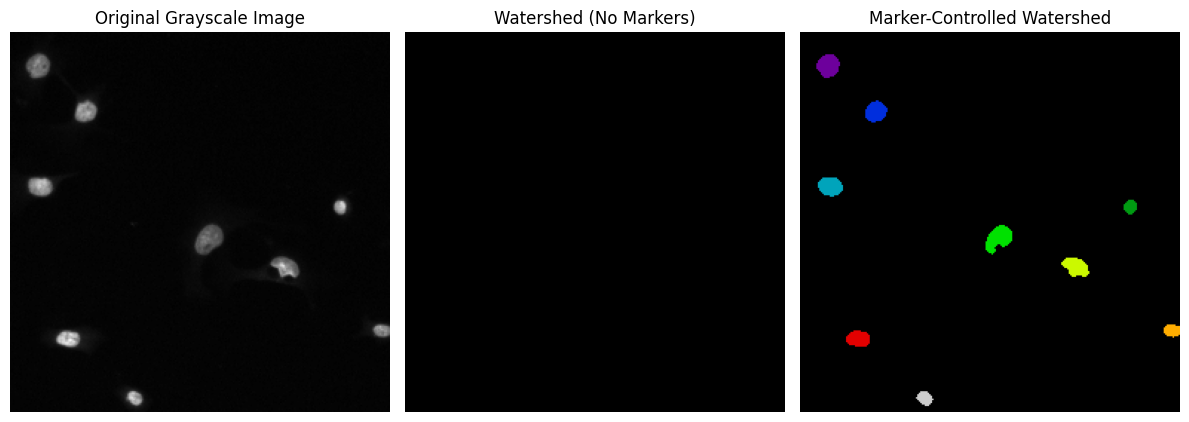

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(gray, cmap="gray")
plt.title("Original Grayscale Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(labels_no_markers, cmap="nipy_spectral")
plt.title("Watershed (No Markers)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(labels_markers, cmap="nipy_spectral")
plt.title("Marker-Controlled Watershed")
plt.axis("off")

plt.tight_layout()
plt.show()

## Conclusion

Watershed without markers fails to produce meaningful segmentation due to the lack of reliable region initialization, often resulting in poor or incomplete separation of nuclei.

In contrast, marker-controlled watershed successfully separates individual nuclei by guiding region growth using predefined markers, thereby reducing over-segmentation and improving the quality of segmentation.

This experiment demonstrates the importance of marker initialization in watershed-based segmentation, especially for separating touching or overlapping cell nuclei.